In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices, SpectralConnectivity
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'misc',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'misc',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [3]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
subj_list = ['008']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard', 'Oddball'];

naff_cond = ['10', '110'];

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        epochs.filter(0.05,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]

        mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)
   
        
        """Average Baseline"""
        epochs_aff_odd_norm1 =[] 
        for ii,ch in enumerate(epochs_aff_odd.ch_names):
            x = np.hstack(epochs_aff_odd.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
        
            x_mean=x.mean() # mean of all the freqs across all the complete experiment session.
            epochs_aff_odd_norm=[]    
            for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
                epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
            epochs_aff_odd_norm1.append(epochs_aff_odd_norm)
        epochs_aff_odd_norm1 = np.array(epochs_aff_odd_norm1)
        epochs_aff_odd_norm1 = np.rollaxis(epochs_aff_odd_norm1,1) # normalized epoch data
        
        epochs_aff_odd1 = mne.EpochsArray(epochs_aff_odd_norm1,  epochs_aff_odd.info, events=epochs_aff_odd.events, tmin=epochs_aff_odd.tmin)
        
        
        """Average Baseline"""
        epochs_aff_typ_norm1 =[] 
        for ii,ch in enumerate(epochs_aff_typ.ch_names):
            x = np.hstack(epochs_aff_typ.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
        
            x_mean=x.mean() # mean of all the freqs across all the complete experiment session.
            epochs_aff_typ_norm=[]    
            for jj in range(epochs_aff_typ.get_data()[:, ii, :].shape[0]):
                epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
            epochs_aff_typ_norm1.append(epochs_aff_typ_norm)
        epochs_aff_typ_norm1 = np.array(epochs_aff_typ_norm1)
        epochs_aff_typ_norm1 = np.rollaxis(epochs_aff_typ_norm1,1) # normalized epoch data
        
        epochs_aff_typ1 = mne.EpochsArray(epochs_aff_typ_norm1,  epochs_aff_typ.info, events=epochs_aff_typ.events, tmin=epochs_aff_typ.tmin)

seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names

ch_picks =['Fz','F4','F8','FC2','FC6','Cz', 'C4','CP2','CP6','Pz','P4']
ch_picks.extend(seed_chs)
epochs_aff_odd1.pick(ch_picks)
epochs_aff_typ1.pick(ch_picks)

Adding metadata with 9 columns
431 matching events found
No baseline correction applied
Setting up band-pass filter from 0.05 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 13201 samples (66.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:40: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9 has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:46: RuntimeWarning: filter_length (13201) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(0.05,30)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 6

Dropped 0 epochs: 
Dropped 103 epochs: 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152


C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:60: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = np.hstack(epochs_aff_odd.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:64: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureW

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:64: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.p

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:64: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.p

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:64: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for jj in range(epochs_aff_odd.get_data()[:, ii, :].shape[0]):
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.p

Not setting metadata
50 matching events found
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:65: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_odd_norm.append(((epochs_aff_odd.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

0 projection items activated


C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:76: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = np.hstack(epochs_aff_typ.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:80: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for jj in range(epochs_aff_typ.get_data()[:, ii, :].shape[0]):
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureW

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:76: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  x = np.hstack(epochs_aff_typ.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)
C:\Users\malann\A

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

Not setting metadata
50 matching events found


C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1215023373.py:81: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_aff_typ_norm.append(((epochs_aff_typ.get_data()[jj, ii, :]-x_mean)/x_mean)) # applying normalaization on each trail
C:\U

No baseline correction applied
0 projection items activated


Number of events,50
Events,1: 50
Time range,-3.000 – 6.000 s
Baseline,off


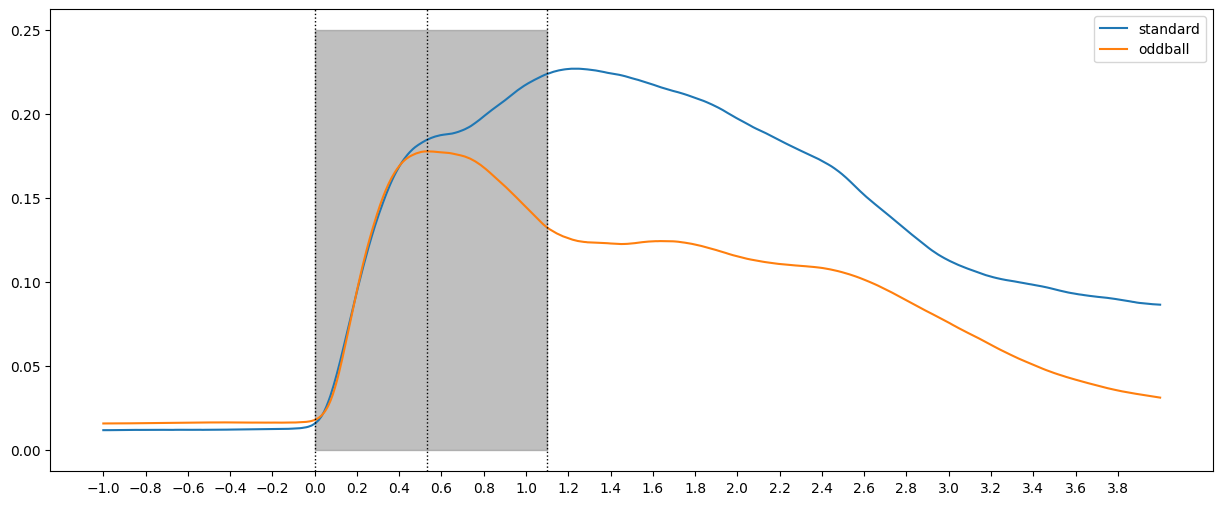

In [4]:
tmin = -1
tmax = 4
Dynmo_odd = epochs_aff_odd.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_odd= Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2]).mean(axis=0)

Dynmo_typ = epochs_aff_typ.copy().crop(tmin,tmax).get_data(picks='DynL(lc)')
Dynmo_typ= Dynmo_typ.reshape(Dynmo_typ.shape[0],Dynmo_typ.shape[2]).mean(axis=0)

plt.figure(figsize=(15,6))

time= epochs_aff_typ.copy().crop(-1,tmax).times

plt.plot(epochs_aff_typ.copy().crop(-1,tmax).times,Dynmo_typ)
plt.plot(epochs_aff_odd.copy().crop(-1,tmax).times,Dynmo_odd)

x=np.arange(tmin,tmax,0.2)

plt.xticks(x)

f_max_time = np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[2]).mean(axis=0))/200

plt.axvline(0, linewidth=1, color="black", linestyle=":")

plt.axvline(f_max_time, linewidth=1, color="black", linestyle=":")

plt.axvline(1.1, linewidth=1, color="black", linestyle=":")
plt.fill_betweenx(np.array((0,0.25)), 1.1,0,color='gray', alpha=0.5)

plt.legend(['standard','oddball'])


# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time, 0] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5, 1.5] #1.5

In [5]:
# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time, 0] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5, 1.5] #1.5

In [ ]:
""""Coherence"""

# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time, 0] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5, 1.5] #1.5

for tmin_coh, tmax_coh in zip(tmin_coh_lst, tmax_coh_lst):

    picks = mne.pick_types(epochs_aff_odd1.info, eeg=True, dbs=True, emg= False,stim=False, eog=False,
                           exclude='bads')

    epochs_aff_odd1.pick(['eeg','dbs'])
    epochs_aff_typ1.pick(['eeg','dbs'])
    
    # Use 'DBS' channels as seed
            
    seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
    coh_diff = []
    for seed_ch in seed_chs:
        
        picks_ch_names = epochs_aff_odd1.ch_names
        # Create seed-target indices for connectivity computation
        seed = picks_ch_names.index(seed_ch)
        targets = np.arange(len(picks))
        indices = seed_target_indices(seed, targets)    
    
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
        min_freq = (4, 8,13,21)
        max_freq = (7, 12,20,30)    
        
        # Define wavelet frequencies and number of cycles
        cwt_freqs = np.arange(1, 41, 1)
        cwt_n_cycles = 7
    
        # Run the connectivity analysis using 2 parallel jobs
        con_odd = spectral_connectivity_epochs(
            epochs_aff_odd1, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
    
        con_typ = spectral_connectivity_epochs(
            epochs_aff_typ1, indices=indices,
            method='coh', mode='cwt_morlet', sfreq=sfreq, fmin = min_freq, fmax = max_freq, faverage =True, tmin = tmin_coh, tmax =tmax_coh,
            cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=30)
    
        times = con_odd.times
        freqs = con_odd.freqs
    
        # Mark the seed channel with a value of 1.0, so we can see it in the plot
        # con_odd.get_data()[np.where(indices[1] == seed)] = 1.0
        # con_typ.get_data()[np.where(indices[1] == seed)] = 1.0
    
        #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
        tfr_odd = mne.time_frequency.AverageTFR(epochs_aff_odd1.info, con_odd.get_data(), times, freqs, len(epochs_aff_odd1))
        #tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)
    
        tfr_typ = mne.time_frequency.AverageTFR(epochs_aff_typ1.info, con_typ.get_data(), times, freqs, len(epochs_aff_typ1))
        #tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)
        
        # TFR differences in freq bands and time period 0 to 1.5s
    
        tfr = tfr_odd- tfr_typ
    
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
            
        n_channels = len(tfr.copy().pick('eeg').ch_names)
        X1 = []
        for n, band in enumerate(freq_band):
            tfr_ch = []
            for ch in range(n_channels):
                tfr_ch.append((tfr.data[:,:,:].mean(axis=2)[ch,n]))
    
            tfr_ch = np.array(tfr_ch).reshape(n_channels,1)   
            X1.append(tfr_ch)
    
        coh_diff.append(X1)
    
    coh_diff = np.array(coh_diff)
    
    file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh}_{tmax_coh}_ipsi"

    np.save(file, coh_diff)

In [ ]:
""""Coherence"""

# Define different time windows to look for coherence in Error detection and Error correction

tmin_coh_lst = [0, f_max_time, 0] #0 # Error detection, Error correction, Full time
tmax_coh_lst = [f_max_time, 1.5, 1.5] #1.5

for tmin_coh, tmax_coh in zip(tmin_coh_lst, tmax_coh_lst):

    picks = mne.pick_types(epochs_aff_odd1.info, eeg=True, dbs=True, emg= False,stim=False, eog=False,
                           exclude='bads')

    epochs_aff_odd1.pick(['eeg','dbs'])
    epochs_aff_typ1.pick(['eeg','dbs'])
    
    # Use 'DBS' channels as seed
            
    seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
    coh_diff = []
    for seed_ch in seed_chs:
        
        picks_ch_names = epochs_aff_odd1.ch_names
        # Create seed-target indices for connectivity computation
        seeds = np.array([picks_ch_names.index(seed_ch)])
        targets = np.arange(len(picks))
        targets = np.delete(targets, seeds)
        indices = seed_target_indices(seeds, targets)    
    
        freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
        min_freq = (4, 8,13,21)
        max_freq = (7, 12,20,30)    
        gc_odd = [] 
      
        # Generate connectivity indices


        bivar_indices = seed_target_indices(seeds, targets)
        multivar_indices = ([seeds], [targets])

        # Compute CaCoh & MIC
        gc_odd.append(spectral_connectivity_epochs(
            epochs_aff_odd1.copy().crop(0,1.5).get_data(), method=["gc"], indices=multivar_indices, sfreq=sfreq, fmin=4, fmax=30
        ))

        gc_typ.append(spectral_connectivity_epochs(
            epochs_aff_typ1.copy().crop(0,1.5).get_data(), method=["gc"], indices=multivar_indices, sfreq=sfreq, fmin=4, fmax=30
        ))
        
    

# Load coherence 

In [6]:
file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[2]}_ipsi.npy"
coh_diff = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[2]}_ipsi.npy"
coh_diff_permuted= np.load(file)


file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_ED = np.load(file) # Error Detection file 

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[0]}_{tmax_coh_lst[0]}_ipsi.npy"
coh_diff_permuted_ED= np.load(file)

file = file = f"{base_dir}coh_diff_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_EC = np.load(file)  # Error Correction file 

file = f"{base_dir}coh_diff_permuted_2000_{sub}_{st}_{tmin_coh_lst[1]}_{tmax_coh_lst[1]}_ipsi.npy"
coh_diff_permuted_EC= np.load(file)




In [ ]:
# Select Error Detection or Error Correction

#coh_diff = coh_diff_ED
#coh_diff_permuted = coh_diff_permuted_ED


In [ ]:
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd1.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


Histogram and pvalue

Text(0.5, 0.98, 'C4')

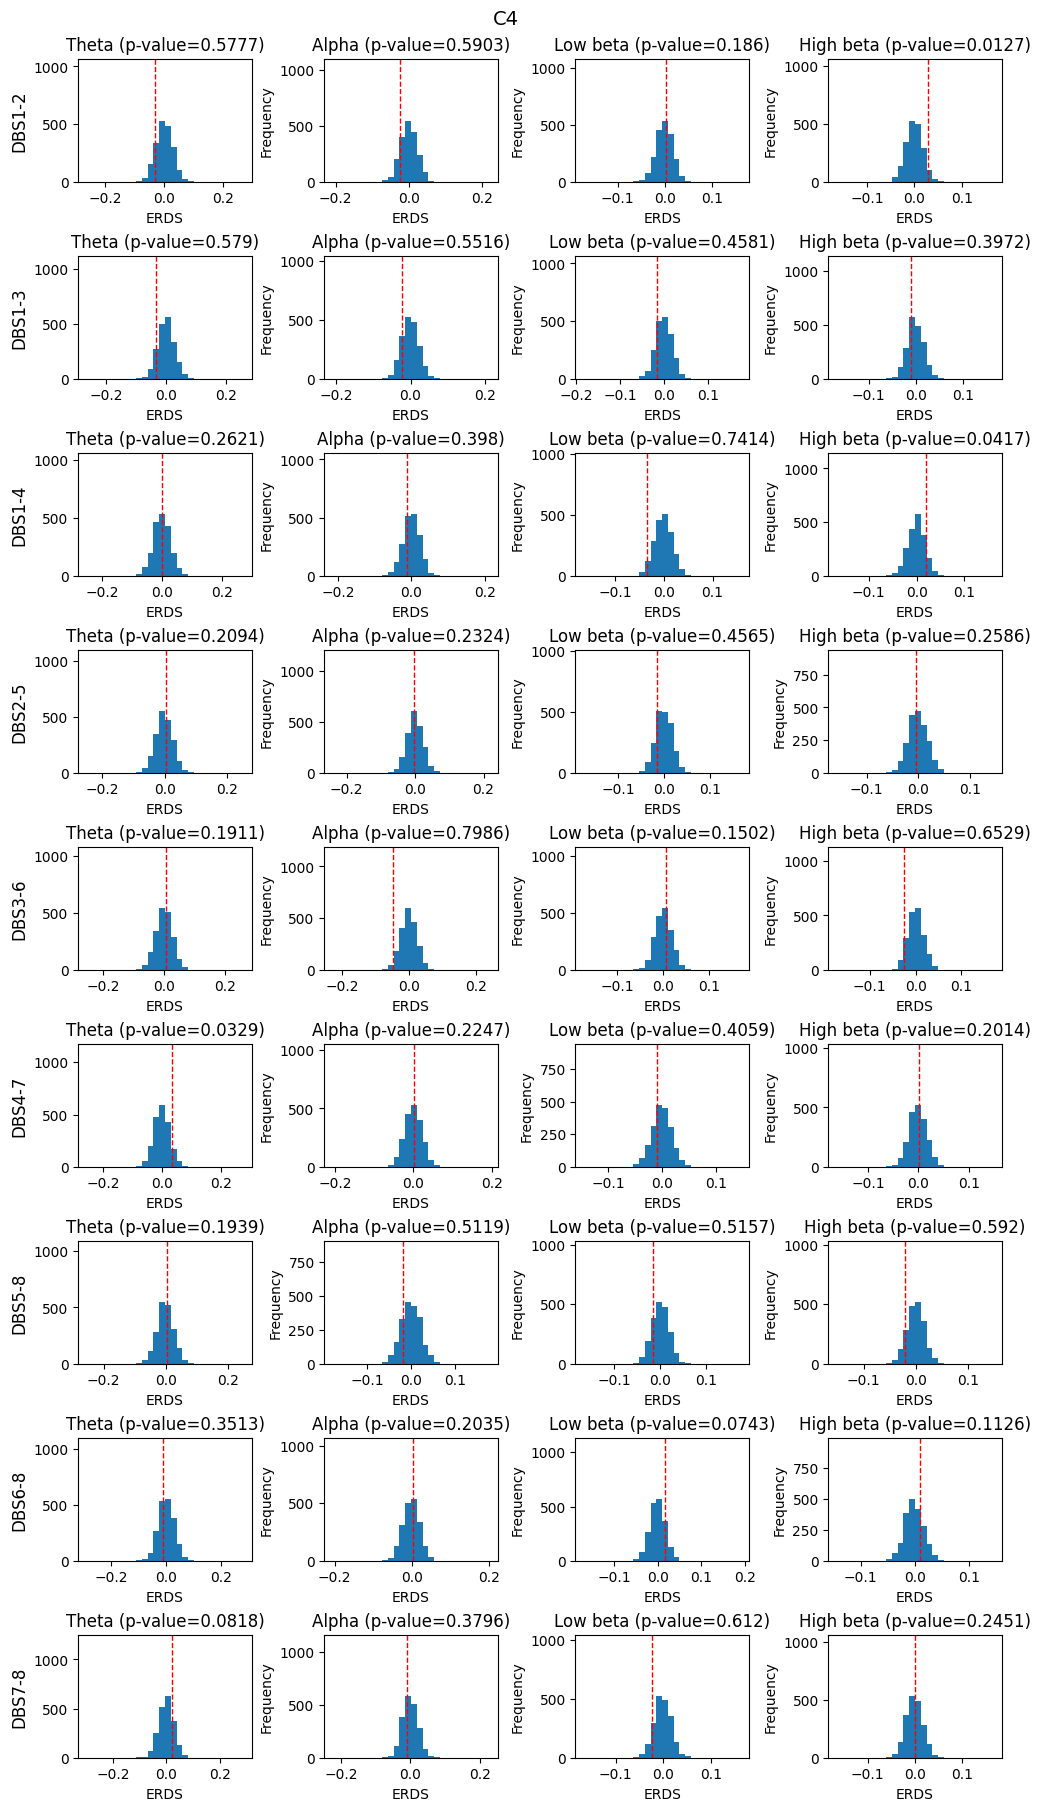

In [7]:
seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
chl_list = epochs_aff_odd1.copy().pick('eeg').ch_names
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
n_channels = len(epochs_aff_odd1.copy().pick('eeg').ch_names)
chl_list = ['C4']


fig, axes = plt.subplots(len(seed_chs), 4, figsize=(10,18),layout="constrained")

mask = []

for n_seed, (seed_ch, ax) in enumerate(zip(seed_chs, axes)):
    mask1 =[]
    for nfrq, band in enumerate(freq_band):

        mask2 = []
        for nchls, ch in enumerate(chl_list):

          
            values, bins, _ = ax[nfrq].hist(coh_diff_permuted[:, n_seed, nfrq, nchls, :])
                      
            total_area = sum(np.diff(bins)*values)
            
            if coh_diff[n_seed, nfrq, nchls, : ][0] <= coh_diff_permuted[:, n_seed, nfrq, nchls, :].max():
            
                values, bins = np.histogram(coh_diff_permuted[:, n_seed, nfrq, nchls, :], range=(coh_diff[n_seed, nfrq, nchls, : ][0],coh_diff_permuted[:, n_seed, nfrq, nchls, :].max()))
                right_area = sum(np.diff(bins)*values)
                pval = right_area/total_area
                pval_r = round(pval, 4)
            else:
                pval_r = 0

            if pval <=0.05:
                mask2.append(pval)
            else:
                mask2.append(0)

            
            ax[nfrq].axvline(coh_diff[n_seed, nfrq, nchls, : ], color='r', linestyle='dashed', linewidth=1)
            ax[nfrq].set_ylabel('Frequency')
            ax[nfrq].set_xlabel('ERDS')

            ax[nfrq].set_title(f'{band} (p-value={pval_r})' )
            ax[nfrq].margins(1, 1)
        ax[0].set_ylabel(seed_ch, size='large')
    
        mask1.append(mask2)
    mask.append(mask1)
mask = np.array(mask)
fig.suptitle(chl_list[0], fontsize=14)


calculating p values

In [8]:
seed_chs = epochs_aff_odd1.copy().pick('dbs').ch_names
chl_list = epochs_aff_odd1.copy().pick('eeg').ch_names
freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']

pvals = []
for n_seed, (seed_ch, ax) in enumerate(zip(seed_chs, axes)):
    pvals1 = [] 
    for nfrq, band in enumerate(freq_band):

        pvals2 = []
        for nchls, ch in enumerate(chl_list):
         
            values, bins = np.histogram(coh_diff_permuted[:, n_seed, nfrq, nchls, :])
                      
            total_area = sum(np.diff(bins)*values)
            
            if coh_diff[n_seed, nfrq, nchls, : ][0] <= coh_diff_permuted[:, n_seed, nfrq, nchls, :].max():
            
                values, bins = np.histogram(coh_diff_permuted[:, n_seed, nfrq, nchls, :], range=(coh_diff[n_seed, nfrq, nchls, : ][0],coh_diff_permuted[:, n_seed, nfrq, nchls, :].max()))
                right_area = sum(np.diff(bins)*values)
                pval = right_area/total_area
                pval_r = round(pval, 4)
            else:
                pval_r = 0
            
            pvals2.append(pval_r)
        pvals2 = np.array(pvals2).reshape(n_channels,1)
   
        pvals1.append(pvals2)
    pvals.append(pvals1)
pvals = np.array(pvals)


FDR correction for multiple comparison 

In [9]:
alpha = 0.05
pval_bonferroni = []
pval_fdr = []
mask_fdr = []

for nfrq, band in enumerate(freq_band):
    pval_bonferroni1 = []
    pval_fdr1 = []
    mask_fdr1 = []
    
    for nchls, ch in enumerate(chl_list):
        pvals_band = pvals[:,nfrq,nchls,:]
        n_samples , n_tests = pvals_band.shape
        reject_bonferroni, p_bon = mne.stats.bonferroni_correction(pvals_band, alpha=alpha)

        reject_fdr, p_fdr = mne.stats.fdr_correction(pvals_band, alpha=alpha, method="indep")

        mask_fdr1.append(reject_fdr)
        pval_bonferroni1.append(p_bon)
        pval_fdr1.append(p_fdr)
        
    pval_bonferroni.append(pval_bonferroni1)
    pval_fdr.append(pval_fdr1)
    mask_fdr.append(mask_fdr1)
    
pval_bonferroni = np.rollaxis(np.array(pval_bonferroni),2,0)
pval_fdr = np.rollaxis(np.array(pval_fdr),2,0)
mask_fdr = np.rollaxis(np.array(mask_fdr),2,0)

In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(coh_diff[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2,mask=mask_fdr[n_ch,n,:,:], mask_params=mask_params, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")
masked_coh = mask_fdr*coh_diff

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [10]:
# cluster size thresholding. Selecting clusters with more than 3 electrodes


# check only for ipsilasional channels
masked_coh = np.multiply(mask_fdr,coh_diff)

mask_cluster_size = np.zeros(masked_coh.shape)
mask_cluster_vol = np.zeros(masked_coh.shape)

adj, names = mne.channels.find_ch_adjacency(epochs_aff_odd1.info, 'eeg')

clus_size_thres = 2

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
sig_clus_vol = []
sig_dbs_ch = []
sig_band_ch = []
sig_eeg_ch = []



for n_ch, seed_ch in enumerate(seed_chs):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, band in enumerate(freq_band):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        for n_eeg, ch_eeg in enumerate(tfr_evoked.ch_names):
            if tfr_evoked.get_data()[n_eeg]>0.001:
                neigh_idx = np.where(adj[n_eeg, :].toarray().ravel())[0]
                neigh_names = [names[i] for i in neigh_idx]
                #print(f"{tfr_evoked.ch_names[n_eeg]} is next to {neigh_names}")
                
                ch_neigh_names = []
                
                for n_neigh, ch_neigh in enumerate(neigh_names):
                    if tfr_evoked.copy().pick(ch_neigh).get_data()>0.001:
                        ch_neigh_names.append(ch_neigh)
                cluster_size = len(ch_neigh_names)
                # print(cluster_size)
                #print(ch_neigh_names)
                if cluster_size>=clus_size_thres:
                    mask_cluster_amp = []
                    mask_cluster_ind = []

                    #print(ch_neigh_names)
                    for n_cs, cs in enumerate(ch_neigh_names):
                        cs_ind = names.index(cs)

                        #print(cs)
                        #print(cs_ind)
                        mask_cluster_size[n_ch,n,cs_ind,:] = masked_coh[n_ch,n,cs_ind,:]

                        mask_cluster_amp.append(masked_coh[n_ch,n,cs_ind,:])
                        mask_cluster_ind.append(cs_ind)
                    # volume of the cluster 
                    sig_clus_vol.append(sum(mask_cluster_amp)*len(mask_cluster_amp))
                    sig_clus_vol1 = sum(mask_cluster_amp)*len(mask_cluster_amp)
                    #print(mask_cluster_ind)
                    #print(sum(mask_cluster_amp))

print(sig_clus_vol)


for n_ch, seed_ch in enumerate(seed_chs):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, band in enumerate(freq_band):
        tfr_evoked = mne.EvokedArray(masked_coh[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        for n_eeg, ch_eeg in enumerate(tfr_evoked.ch_names):
            if tfr_evoked.get_data()[n_eeg]>0.001:
                neigh_idx = np.where(adj[n_eeg, :].toarray().ravel())[0]
                neigh_names = [names[i] for i in neigh_idx]
                #print(f"{tfr_evoked.ch_names[n_eeg]} is next to {neigh_names}")
                
                ch_neigh_names = []
                
                for n_neigh, ch_neigh in enumerate(neigh_names):
                    if tfr_evoked.copy().pick(ch_neigh).get_data()>0.001:
                        ch_neigh_names.append(ch_neigh)
                cluster_size = len(ch_neigh_names)
                #print(cluster_size)
                #print(ch_neigh_names)
                if cluster_size>=clus_size_thres:
                    
                    mask_cluster_amp = []
                    mask_cluster_ind = []
                    #print(ch_neigh_names)
                    for n_cs, cs in enumerate(ch_neigh_names):
                        cs_ind = names.index(cs)

                        #print(cs)
                        #print(cs_ind)
                        mask_cluster_size[n_ch,n,cs_ind,:] = masked_coh[n_ch,n,cs_ind,:]

                        mask_cluster_amp.append(masked_coh[n_ch,n,cs_ind,:])
                        mask_cluster_ind.append(cs_ind)
                    # volume of the cluster 
                    sig_clus_vol1 = sum(mask_cluster_amp)*len(mask_cluster_amp)
                    #print(mask_cluster_ind)
                    if sig_clus_vol1 == max(sig_clus_vol):
                        
                        sig_eeg_ch_amp = mask_cluster_amp
                        #print(mask_cluster_ind)
                        sig_eeg_ch = mask_cluster_ind
                        for c_ind in mask_cluster_ind:
                            mask_cluster_vol[n_ch,n,c_ind,:] = masked_coh[n_ch,n,c_ind,:]
                            #sig_eeg_ch.append(c_ind)
                        sig_dbs_ch.append(n_ch)
                        sig_band_ch.append(n)
                            
MaxVal, secondMax = sorted(sig_eeg_ch_amp)[-2:]
index_max = sig_eeg_ch_amp.index(MaxVal)
index_secondMax = sig_eeg_ch_amp.index(secondMax)
sig_eeg_ch_best_2 = [sig_eeg_ch[index_max], sig_eeg_ch[index_secondMax]]                  

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 11
[array([0.21136772]), array([0.20789338]), array([0.78920389]), array([0.18558727]), array([0.193224]), array([0.16847247]), array([0.72301739]), array([0.1522241])]


In [11]:
sig_eeg_ch_best_2

[8, 2]

In [ ]:
fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_size[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [ ]:
# Selecting best DBS contact based on Volume of the cluster (amplitude of the cluster* number of electrodes) 

fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=len(seed_chs), ncols=len(freq_band), layout="constrained")

freq_band = ['Theta', 'Alpha', 'Low beta', 'High beta']
min_freq = [4, 8,13,21]
max_freq = [7, 12,20,30]
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)
for n_ch, (axes_row, seed_ch) in enumerate(zip(axes, seed_chs)):

    n_channels = len(epochs_aff_odd.copy().pick('eeg').ch_names)
    for n, (ax, band) in enumerate(zip(axes_row, freq_band)):
        tfr_evoked = mne.EvokedArray(mask_cluster_vol[n_ch,n,:,:], epochs_aff_odd1.copy().pick('eeg').info)
        tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5),cmap='RdBu_r',axes=ax,show=False, colorbar =False)
        ax.set_title("%s %s" % (seed_ch.upper(), band), fontsize=14)


In [12]:
print(sig_dbs_ch)
print(sig_band_ch)
print(sig_eeg_ch)
print(sig_eeg_ch_best_2)

[4]
[2]
[2, 6, 8, 10]
[8, 2]


C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1391054266.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_all_d = np.zeros(epochs_aff_odd.copy().pick('eeg').get_data().shape[1]).reshape(epochs_aff_odd.copy().pick('eeg').get_data().shape[1],1)
C:\Users\malann\AppData\Local\Temp\ipykernel_632696\1391054266.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  ep_all_d = np.zeros(epochs_aff_odd.copy().pick('eeg').get_data().shape[1]).reshape(epochs_aff_odd.copy().pick('eeg').get_data().shape[1],1)


Text(0.5, 1.0, 'DBS3-6 Low beta')

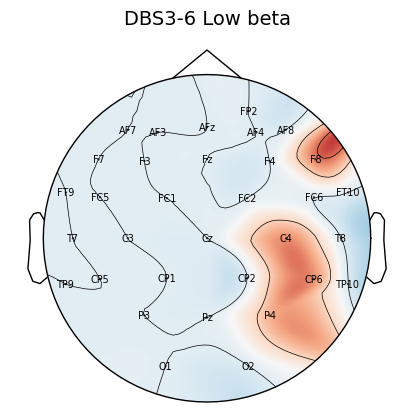

In [13]:
# Selecting best DBS contact based on Volume of the cluster (amplitude of the cluster* number of electrodes) 

ep_all_d = np.zeros(epochs_aff_odd.copy().pick('eeg').get_data().shape[1]).reshape(epochs_aff_odd.copy().pick('eeg').get_data().shape[1],1)
ep_all = mne.EvokedArray(ep_all_d, epochs_aff_odd.copy().pick('eeg').info)


fig, ax = plt.subplots(1,1)
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
                    linewidth=0, markersize=8)


for i, n in enumerate(epochs_aff_odd1.copy().pick('eeg').ch_names):
    ep_all_d[ep_all.ch_names.index(n)] = mask_cluster_vol[sig_dbs_ch[0],sig_band_ch[0],i,:]



tfr_evoked = mne.EvokedArray(ep_all_d, epochs_aff_odd.copy().pick('eeg').info)
tfr_evoked.plot_topomap(0.0,show_names=True,size=2, vlim=(-0.8e5,1e5), cmap='RdBu_r', colorbar =False, show=False,image_interp='cubic', extrapolate='head', border='mean', res=64, axes = ax)

ax.set_title(f"{epochs_aff_odd1.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]} {freq_band[sig_band_ch[0]]}", fontsize=14)


Plot Significant TFR Coherence

In [14]:
""""Coherence and Granger Causality"""

sig_dbs_ch
sig_eeg_ch_best_2

sig_eeg = []
for n, i in enumerate(sig_eeg_ch_best_2):
    sig_eeg.append(epochs_aff_odd1.copy().pick(['eeg']).ch_names[sig_eeg_ch_best_2[n]])


epochs_aff_odd2 = epochs_aff_odd1.copy().pick(sig_eeg)

sig_seed_ch = [epochs_aff_odd1.copy().pick(['dbs']).ch_names[sig_dbs_ch[0]]]

picks = mne.pick_types(epochs_aff_odd1.info, eeg=True, dbs=False, emg= False,stim=False, eog=False,
                       exclude='bads')

epochs_aff_odd1.pick(['eeg','dbs'])
epochs_aff_typ1.pick(['eeg','dbs'])

# Use 'DBS' channels as seed
        
coh_diff = []
for seed_ch in sig_seed_ch:
    
    picks_ch_names = epochs_aff_odd1.ch_names
    # Create seed-target indices for connectivity computation
    seed = np.array([picks_ch_names.index(seed_ch)])
    targets = np.arange(len(picks))
    indices = seed_target_indices(seed, targets)
    
    min_freq = (4, 8,13,21)
    max_freq = (7, 12,20,30)

    
    # Define wavelet frequencies and number of cycles
    cwt_freqs = np.arange(1, 41, 1)
    cwt_n_cycles = 7

    # Run the connectivity analysis using n parallel jobs
    con_odd = spectral_connectivity_epochs(
        epochs_aff_odd1, indices=indices,
        method='coh', mode='cwt_morlet', sfreq=sfreq, 
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2)

    con_typ = spectral_connectivity_epochs(
        epochs_aff_typ1, indices=indices,
        method='coh', mode='cwt_morlet', sfreq=sfreq, 
        cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2)

    times = con_odd.times
    freqs = con_odd.freqs

    # Mark the seed channel with a value of 1.0, so we can see it in the plot
    # con_odd.get_data()[np.where(indices[1] == seed)] = 1.0
    # con_typ.get_data()[np.where(indices[1] == seed)] = 1.0

    #layout = mne.find_layout(epochs.info, 'eeg')  # use full layout
    tfr_odd = mne.time_frequency.AverageTFR(epochs_aff_odd1.copy().pick('eeg').info, con_odd.get_data(), times, freqs, len(epochs_aff_odd1))
    #tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

    tfr_typ = mne.time_frequency.AverageTFR(epochs_aff_typ1.copy().pick('eeg').info, con_typ.get_data(), times, freqs, len(epochs_aff_typ1))
    #tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)
    
    # TFR differences in freq bands and time period 0 to 1.5s

    tfr_diff = tfr_odd- tfr_typ

    # Generate connectivity indices
    target_gc = []
    for i in sig_eeg:
        target_gc.append(picks_ch_names.index(i))
    target_gc = np.array(target_gc)
    
    indices_dbs_eeg = ([seed], [target_gc])  # DBS => EEG
    indices_eeg_dbs = ([target_gc], [seed])  # EEG => DBS

    # Compute Granger Causality DBS => EEG
    
    gc_odd_dbs_eeg = spectral_connectivity_epochs(
        epochs_aff_odd1, method=["gc"], indices=indices_dbs_eeg, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )
    
    gc_typ_dbs_eeg = spectral_connectivity_epochs(
        epochs_aff_typ1, method=["gc"], indices=indices_dbs_eeg, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )
   
    # Compute Granger Causality EEG => DBS
    gc_odd_eeg_dbs = spectral_connectivity_epochs(
        epochs_aff_odd1, method=["gc"], indices=indices_eeg_dbs, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )

    gc_typ_eeg_dbs = spectral_connectivity_epochs(
        epochs_aff_typ1, method=["gc"], indices=indices_eeg_dbs, mode='cwt_morlet',
        sfreq=sfreq, cwt_freqs=cwt_freqs, cwt_n_cycles=cwt_n_cycles, n_jobs=2,
            rank=(np.array([1]), np.array([1])),
            gc_n_lags=10
    )


Connectivity computation...
    computing connectivity for 11 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..2


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:995: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), -3 – 6 s, baseline off, ~13.8 MB, data loaded,
 '101': 50>, so metadata was not modified.
  data.add_annotations_to_metadata(overwrite=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 5..6


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 23..24


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 25..26


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 31..32


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 35..36


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 39..40


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 43..44


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 49..50


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 11 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epochs 1..2


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:995: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), -3 – 6 s, baseline off, ~13.8 MB, data loaded,
 '1': 50>, so metadata was not modified.
  data.add_annotations_to_metadata(overwrite=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 5..6


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 23..24


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 25..26


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 31..32


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 35..36


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 39..40


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 43..44


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 49..50


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: GC
    computing cross-spectral density for epochs 1..2


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:995: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), -3 – 6 s, baseline off, ~13.8 MB, data loaded,
 '101': 50>, so metadata was not modified.
  data.add_annotations_to_metadata(overwrite=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 5..6


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 23..24


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 25..26


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 31..32


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 35..36


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 39..40


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 43..44


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 49..50


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Computing GC for connection 1 of 1


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


  0%|          | frequency blocks : 0/20 [00:00<?,       ?it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: GC
    computing cross-spectral density for epochs 1..2
    computing cross-spectral density for epochs 3..4


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:995: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), -3 – 6 s, baseline off, ~13.8 MB, data loaded,
 '1': 50>, so metadata was not modified.
  data.add_annotations_to_metadata(overwrite=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 5..6
    computing cross-spectral density for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..20
    computing cross-spectral density for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 23..24
    computing cross-spectral density for epochs 25..26


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 27..28
    computing cross-spectral density for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 31..32


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 33..34


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 35..36
    computing cross-spectral density for epochs 37..38


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 39..40


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 43..44
    computing cross-spectral density for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 47..48


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 49..50
Computing GC for connection 1 of 1


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


  0%|          | frequency blocks : 0/20 [00:00<?,       ?it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: GC
    computing cross-spectral density for epochs 1..2


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:995: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), -3 – 6 s, baseline off, ~13.8 MB, data loaded,
 '101': 50>, so metadata was not modified.
  data.add_annotations_to_metadata(overwrite=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 5..6


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 9..10


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..12
    computing cross-spectral density for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


    computing cross-spectral density for epochs 15..16


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 17..18


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 21..22


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 23..24


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 25..26


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 29..30


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 31..32


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 35..36
    computing cross-spectral density for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 39..40


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 43..44


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 45..46


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 49..50


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


Computing GC for connection 1 of 1


  0%|          | frequency blocks : 0/20 [00:00<?,       ?it/s]

[Connectivity computation done]
Connectivity computation...
    computing connectivity for 1 connections
    using t=-3.000s..6.000s for estimation (1801 points)
    frequencies: 1.0Hz..40.0Hz (40 points)
    using CWT with Morlet wavelets to estimate spectra
    the following metrics will be computed: GC
    computing cross-spectral density for epochs 1..2


C:\Users\malann\AppData\Roaming\Python\Python310\site-packages\mne_connectivity\spectral\epochs.py:995: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), -3 – 6 s, baseline off, ~13.8 MB, data loaded,
 '1': 50>, so metadata was not modified.
  data.add_annotations_to_metadata(overwrite=True)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 3..4


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 5..6


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 7..8


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 9..10


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 11..12


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 13..14


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 15..16


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 17..18


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 19..20


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


    computing cross-spectral density for epochs 21..22
    computing cross-spectral density for epochs 23..24


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 25..26
    computing cross-spectral density for epochs 27..28


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 29..30


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 31..32
    computing cross-spectral density for epochs 33..34


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 35..36
    computing cross-spectral density for epochs 37..38


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


    computing cross-spectral density for epochs 39..40


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 41..42


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 43..44


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 45..46


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


    computing cross-spectral density for epochs 47..48


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.6s finished


    computing cross-spectral density for epochs 49..50


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Computing GC for connection 1 of 1


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.8s finished


  0%|          | frequency blocks : 0/20 [00:00<?,       ?it/s]

[Connectivity computation done]


In [ ]:
tfr_odd_dbs_eeg = mne.time_frequency.AverageTFR(epochs_aff_odd1.copy().pick('C4').info, gc_odd_dbs_eeg.get_data(), times, freqs, len(epochs_aff_odd1))
#tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_typ_dbs_eeg = mne.time_frequency.AverageTFR(epochs_aff_odd1.copy().pick('C4').info, gc_typ_dbs_eeg.get_data(), times, freqs, len(epochs_aff_typ1))
#tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_diff_dbs_eeg = tfr_odd_dbs_eeg- tfr_typ_dbs_eeg

tfr_odd_eeg_dbs = mne.time_frequency.AverageTFR(epochs_aff_odd1.copy().pick('C4').info, gc_odd_eeg_dbs.get_data(), times, freqs, len(epochs_aff_odd1))
#tfr_odd.save(data_dir+'tfr_odd'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_typ_eeg_dbs = mne.time_frequency.AverageTFR(epochs_aff_odd1.copy().pick('C4').info, gc_typ_eeg_dbs.get_data(), times, freqs, len(epochs_aff_typ1))
#tfr_typ.save(data_dir+'tfr_typ'+st+seed_ch+'-tfr.h5',overwrite =True)

tfr_diff_eeg_dbs = tfr_odd_eeg_dbs- tfr_typ_eeg_dbs


In [ ]:
CCC = tfr_diff.copy().pick(sig_eeg).data.mean(axis=0)
file = f"{base_dir}CCC_{sub}_{st}"
np.save(file,CCC)

CCC_odd = tfr_odd.copy().pick(sig_eeg).data.mean(axis=0)
file = f"{base_dir}CCC_Oddball_{sub}_{st}"
np.save(file,CCC_odd)

CCC_typ = tfr_typ.copy().pick(sig_eeg).data.mean(axis=0)
file = f"{base_dir}CCC_Standard_{sub}_{st}"
np.save(file,CCC_typ)

GC_dbs_eeg = tfr_diff_dbs_eeg.data.mean(axis=0)
file = f"{base_dir}GC_dbs_eeg_{sub}_{st}"
np.save(file,GC_dbs_eeg)

GC_odd_dbs_eeg = tfr_odd_dbs_eeg.data.mean(axis=0)
file = f"{base_dir}GC_dbs_eeg_Oddball_{sub}_{st}"
np.save(file,GC_odd_dbs_eeg)

GC_typ_dbs_eeg = tfr_typ_dbs_eeg.data.mean(axis=0)
file = f"{base_dir}GC_dbs_eeg_Standard_{sub}_{st}"
np.save(file,GC_typ_dbs_eeg)


GC_eeg_dbs = tfr_diff_eeg_dbs.data.mean(axis=0)
file = f"{base_dir}GC_eeg_dbs_{sub}_{st}"
np.save(file,GC_eeg_dbs)

GC_odd_eeg_dbs = tfr_odd_eeg_dbs.data.mean(axis=0)
file = f"{base_dir}GC_eeg_dbs_Oddball_{sub}_{st}"
np.save(file,GC_odd_eeg_dbs)

GC_typ_eeg_dbs = tfr_typ_eeg_dbs.data.mean(axis=0)
file = f"{base_dir}GC_eeg_dbs_Standard_{sub}_{st}"
np.save(file,GC_typ_eeg_dbs)


In [ ]:
freqs = con_odd.freqs
fig, axis = plt.subplots(1, 1)

tmin = 600
tmax = 900

axis.plot(freqs, CCC_odd[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, CCC_typ[:,600:900].mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(['Oddball', 'Standard'])
fig.suptitle("CCC")

In [ ]:
freqs = con_odd.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, CCC.mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("CCC: Oddball - Standard")

In [ ]:
freqs = gc_odd_dbs_eeg.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, GC_odd_dbs_eeg[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, GC_typ_dbs_eeg[:,600:900].mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(['Oddball', 'Standard'])
fig.suptitle("GC: [dbs => eeg]")

In [ ]:
freqs = gc_odd_eeg_dbs.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, GC_odd_eeg_dbs[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, GC_typ_eeg_dbs[:,600:900].mean(axis=1), linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(['Oddball', 'Standard'])
fig.suptitle("GC: [eeg => dbs]")

In [ ]:
freqs = gc_odd_dbs_eeg.freqs
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, GC_dbs_eeg[:,600:900].mean(axis=1), linewidth=2)
axis.plot(freqs, GC_eeg_dbs[:,600:900].mean(axis=1), linewidth=2)



axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
axis.legend(["GC: [dbs => eeg]", "GC: [eeg => dbs]"])
fig.suptitle('Oddball - Standard')

In [ ]:
# creating a mask to plot on tfr coherence betwwn 0s and 1.5s and significant freq band
tmin = -1
tmax = 3

tmin_mark = tmin_coh_lst[2]
tmax_mark = tmax_coh_lst[2]
fmin_mark = min_freq[sig_band_ch[0]]
fmax_mark = max_freq[sig_band_ch[0]]

mask_tfr_diff = np.full(tfr_diff.copy().crop(tmin,tmax).pick(sig_eeg).data.shape, False)


for n in range(0,tfr_diff.copy().crop(tmin,tmax).data.shape[1]):
    for m in range(0,tfr_diff.copy().crop(tmin,tmax).data.shape[2]):
        if n>fmin_mark and n<fmax_mark and m > (tmin_mark-tmin)*200 and m < (tmax_mark-tmin)*200:
            mask_tfr_diff[:,n,m]= True
            
vmax=0.5
vmin=-0.5
fig, axes = plt.subplots(figsize=(5.5, 2.5*len(sig_eeg_ch_best_2)), nrows=len(sig_eeg_ch_best_2), ncols=1, layout="constrained")
    
title = "GC: [dbs => eeg]"
tfr_diff_dbs_eeg.plot('C4', tmin=tmin,tmax=tmax, axes = axes[0], vmax=vmax,vmin=vmin, mask =mask_tfr_diff[i,:,:] ,mask_style = 'contour', show= False)
axes[0].set_title(title)

title = "GC: [eeg => dbs]"
tfr_diff_eeg_dbs.plot("C4", tmin=tmin,tmax=tmax, axes = axes[1], vmax=vmax,vmin=vmin, mask =mask_tfr_diff[0,:,:] ,mask_style = 'contour', show= False)
axes[1].set_title(title)

In [ ]:
# creating a mask to plot on tfr coherence betwwn 0s and 1.5s and significant freq band
tmin = -1
tmax = 3

tmin_mark = tmin_coh_lst[2]
tmax_mark = tmax_coh_lst[2]
fmin_mark = min_freq[sig_band_ch[0]]
fmax_mark = max_freq[sig_band_ch[0]]

mask_tfr_diff = np.full(tfr_diff.copy().crop(tmin,tmax).pick(sig_eeg).data.shape, False)


for n in range(0,tfr_diff.copy().crop(tmin,tmax).data.shape[1]):
    for m in range(0,tfr_diff.copy().crop(tmin,tmax).data.shape[2]):
        if n>fmin_mark and n<fmax_mark and m > (tmin_mark-tmin)*200 and m < (tmax_mark-tmin)*200:
            mask_tfr_diff[:,n,m]= True
            
vmax=0.5
vmin=-0.5
fig, axes = plt.subplots(figsize=(5.5, 2.5*len(sig_eeg_ch_best_2)), nrows=len(sig_eeg_ch_best_2), ncols=1, layout="constrained")

if len(sig_eeg_ch)>1:
    for i, (ax, ch) in enumerate(zip(axes, tfr_diff.copy().pick(sig_eeg).ch_names)):
        title = 'Oddball - Standrad:' + seed_ch +' vs '+ch 
        tfr_diff.plot(ch, tmin=tmin,tmax=tmax, axes = ax, vmax=vmax,vmin=vmin, mask =mask_tfr_diff[i,:,:] ,mask_style = 'contour', show= False)
        ax.set_title(title)
else:
    title = 'Oddball - Standrad:' + seed_ch +' vs '+ sig_eeg[0]
    tfr_diff.plot(sig_eeg[0], tmin=tmin,tmax=tmax, axes = axes, vmax=vmax,vmin=vmin, mask =mask_tfr_diff[0,:,:] ,mask_style = 'contour', show= False)
    axes.set_title(title)

Coherence Excel sheet 

In [ ]:
df = tfr_typ_dbs_eeg.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Standard'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["DBS=> EEG"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data.csv', mode='a', index=False, header=False)


df = tfr_odd_dbs_eeg.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Oddball'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["DBS=> EEG"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data.csv', mode='a', index=False, header=False)





In [ ]:
df = tfr_typ_eeg_dbs.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Standard'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["EEG=> DBS"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data.csv', mode='a', index=False, header=False)



df = tfr_odd_eeg_dbs.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()

df_mean = (
    df.groupby(["Time_dur", "band"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Oddball'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])
df_mean.insert(6, "Direction", len(df_mean)*["EEG=> DBS"])

header = ["Stage", "Subject", "Condition", "Time", "Freq", "DBS", "Direction", "GC"]
df_mean.to_csv(base_dir+'Oddball_GC_data.csv', mode='a', index=False, header=False)





In [ ]:
df = tfr_typ.copy().pick(sig_eeg).to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


df_mean = (
    df.groupby(["Time_dur", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Standard'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])

df_mean.to_csv(base_dir+'Oddball_Coh_data.csv', mode='a', index=False, header=False)



df = tfr_odd.copy().pick(sig_eeg).to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time} ]': f_max_time, f'[{f_max_time} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}

df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

df["Time_dur"] = pd.cut(
    df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["[4 7]","[8 12]", "[13 20]", "[21 30]"]
time_of_interest = ["[-0.5 0]", f'[0 {f_max_time} ]', f'[{f_max_time} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

df = df[df.band.isin(freq_bands_of_interest)]
df = df[df.Time_dur.isin(time_of_interest)]

df["band"] = df["band"].cat.remove_unused_categories()
df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


df_mean = (
    df.groupby(["Time_dur", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)
df_mean.insert(0,'Stage', len(df_mean)*[st])
df_mean.insert(1,'Subject', len(df_mean)*[sub])
df_mean.insert(2,'Condition', len(df_mean)*['Oddball'])
df_mean.insert(5,'DBS Channel', len(df_mean)*[sig_seed_ch])


df_mean.to_csv(base_dir+'Oddball_Coh_data.csv', mode='a', index=False, header=False)
